In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from data.data_import import (
    load_data, load_ecb_1y_yield,
    fill_liabilities, drop_high_leverage_firms,
    prepare_nig_inputs
)

print(Path.cwd())

c:\Users\vkeenan\OneDrive - Delft University of Technology\Documents\University\QRM\Accenture Project\code


In [2]:
# data import and input panel preparation
ret_daily, bs, coverage = load_data(
    Path.cwd() / "data/raw/Jan2025_Accenture_Dataset_ErasmusCase.xlsx",
    start_date="2012-01-01",
    end_date="2025-12-19",
    enforce_coverage=True,
    coverage_tol=0.95,
    liabilities_scale="auto",
    verbose=True,
)

df_rf = load_ecb_1y_yield(
    startPeriod="2010-01-01",
    endPeriod="2025-12-31",
    out_file="data/raw/ecb_yc_1y_aaa.xml",
    verify_ssl=True,  # recommended if it works
)

df_cal = ret_daily[["date"]].drop_duplicates().sort_values("date").reset_index(drop=True)

debt_daily = fill_liabilities(bs, df_cal)

ret_filt, bs_filt, lev_by_firm, dropped = drop_high_leverage_firms(
    ret_daily,
    bs,
    df_calendar=df_cal,
    debt_daily=debt_daily,
    lev_threshold=8.0,
    lev_agg="median",
    verbose=True,
)

# keep debt panel consistent with filtered firms
keep = set(ret_filt["gvkey"].astype(str).unique())
debt_daily_filt = debt_daily[debt_daily["gvkey"].astype(str).isin(keep)].copy()

nig_df, em_cache = prepare_nig_inputs(ret_filt, bs_filt, df_rf, debt_daily=debt_daily_filt, build_em=False)
print(nig_df.head())
print(nig_df.shape)
print(nig_df.describe())

[load_data] Firms (ret_daily): 46
[load_data] Date range (ret_daily): 2012-01-03 .. 2025-12-19
[load_data] Coverage min/median/max: 0.999 / 1.000 / 1.000
[load_data] liabilities_scale_used: 1e+06
[load_data] QA mcap_reported<=0 rows (raw windowed mkt): 62
Data has been written to data/raw/ecb_yc_1y_aaa.xml
[drop_high_leverage_firms] agg=median, threshold=8.0
[drop_high_leverage_firms] firms before: 46 | after: 36
[drop_high_leverage_firms] dropped firms: 10
    gvkey       date             E          isin  \
0  100022 2012-01-03  3.328431e+10  DE0005190003   
1  100080 2012-01-03  4.268705e+10  DE000BAY0017   
2  100312 2012-01-03  1.469717e+09  DE0007030009   
3  100581 2012-01-03  4.935351e+10  FR0000120321   
4  100957 2012-01-03  2.931851e+10  ES0144580Y14   

                        company country_iso         r             L  
0  BAYERISCHE MOTOREN WERKE AKT         DEU  0.001177  8.576700e+10  
1                      BAYER AG         DEU  0.001177  3.254300e+10  
2              

### Goal

For each firm/date, solve for \(A_t\) in:

$$
E_t = C_{\text{NIG}}(A_t, L_t, r_t, \tau; \vartheta_A),
\qquad
\tau = T - t
$$

where \(C_{\text{NIG}}\) is the NIG‑based equity‑as‑call valuation used by Ahčan & Jovan (Eq. 26).

### Outputs

**Daily asset values**

$$
\hat{A}_t
$$

**Asset log returns**

$$
\Delta \ln \hat{A}_t
$$

#### NIG Components

**NIG log‑mgf**

$$
\kappa(u)
$$

**Esscher parameter \(\theta\)**  
Solving the martingale condition (risk‑neutralization)

$$
\theta \text{ such that the RN drift condition holds}
$$

**NIG call price**

$$
C_{\text{NIG}}(A, L, r, \tau)
$$

via a robust Fourier probability representation.

**Asset inversion**

$$
E \;\longmapsto\; \hat{A}
$$

via Brent root finding (same spirit as the paper’s “uniroot” step).



In [3]:
from nig_apath import NIGParams, invert_assets_weekly_for_firm

gv = "100022"
g = nig_df[nig_df["gvkey"].astype(str) == gv].sort_values("date").copy()

p0 = NIGParams(alpha=15.0, beta=-3.0, delta=0.20, mu=0.00)

bmw_assets_w = invert_assets_weekly_for_firm(g, p0, U=120.0, n=2000)

print("weeks:", len(bmw_assets_w), "NaNs in A_hat:", bmw_assets_w["A_hat"].isna().sum())
print(bmw_assets_w[["date","A_hat","theta","logA","dlogA"]].head())
print(bmw_assets_w[["date","A_hat","theta","logA","dlogA"]].tail())

weeks: 729 NaNs in A_hat: 0
        date         A_hat     theta       logA     dlogA
0 2012-01-06  1.190473e+11  2.640400  25.502787       NaN
1 2012-01-13  1.208258e+11  2.611808  25.517616  0.014829
2 2012-01-20  1.238685e+11  2.656953  25.542486  0.024871
3 2012-01-27  1.244749e+11  2.658302  25.547370  0.004884
4 2012-02-03  1.277593e+11  2.618355  25.573414  0.026044
          date         A_hat     theta       logA     dlogA
724 2025-11-21  2.171518e+11  3.947332  26.103863 -0.009565
725 2025-11-28  2.187759e+11  3.963445  26.111314  0.007451
726 2025-12-05  2.234569e+11  3.982507  26.132485  0.021171
727 2025-12-12  2.231041e+11  4.009114  26.130904 -0.001580
728 2025-12-19  2.218076e+11  4.006823  26.125076 -0.005829


Keep monthly as baseline, but add extra inversion dates during stress  
(without going daily).  
This updates the mapping

$$
E \;\longmapsto\; A
$$

more frequently when equity dynamics suggest the latent asset process may have shifted.

##### Trigger Design

Use equity log‑returns (already in your panel as `logret_mcap`) and define triggers when:

#### **Large absolute daily move**

$$
|\Delta \log E_t| \;>\; q_{0.99}\big(|\Delta \log E|\big)
$$

where the quantile is computed **rolling over the last 252 trading days**, firm‑specific.

#### Inversion Calendar

- all **month‑end** trading dates  
- **plus all trigger dates**  
- *(optional)* plus the next **1–3 days** after a trigger to capture aftershocks


To improve computational efficiency while preserving statistical validity, we use an event-driven inversion calendar to update the implied asset level A^t more frequently during periods of large equity moves. However, because trigger dates oversample the tails of the equity return distribution (selection bias), we do not use the trigger-subsampled series to estimate the NIG parameters. Instead, NIG parameters are estimated on a fixed, regular return grid (e.g., weekly or daily rolling windows), and the trigger mechanism is used only as a state-update device for the equity-to-asset inversion step.

#### EM Input Requirements

What the EM‑input extractor expects:

**Equity series**

$$
\{E_t\}_{t = 1}^{505}
$$

(last 505 observations)

**Risk‑free rate series**

$$
\{r_t\}_{t = 1}^{505}
$$

(last 505 observations)

**Liability level (scalar)**

$$
L
$$

chosen over the window (i.e. last value).

#### Weekly EM Workflow

Define EM dates — for example:

- every **Friday**, or  
- every **5th trading day**.

For each EM date:

1. Call  
   ```
   make_em_inputs(nig_df, gvkey, end_date=em_date, window=505, ...)
   ```
2. Run your EM initializer / estimator (the function referenced in your docstring).
3. Store fitted parameters in a cache:
   ```
   { em_date : p_hat }
   ```

##### Using EM Parameters During Asset Inversion

When inverting assets on the inversion calendar, use the **most recent** parameter estimate:

$$
\hat{p}_{\text{EM date}} \quad \text{such that} \quad \text{EM date} \le \text{inversion date}
$$

#### Summary

- **EM schedule:** weekly, fixed  
- **Inversion schedule:** month‑ends + triggers  
- Both reuse your existing working components


In [4]:
from nig_em import fit_nig_params_from_weekly_assets
from nig_apath import NIGParams

assets_weekly = bmw_assets_w.copy()
p0 = NIGParams(alpha=15.0, beta=-3.0, delta=0.20, mu=0.0)

updates = fit_nig_params_from_weekly_assets(
    assets_weekly,
    p0=p0,
    window_weeks=104,
    refit_every=13,
    use_theta=True,
    prefer_precomputed_theta=True,
    verbose=True,
)

# Key diagnostics:
updates[["date","alpha","alpha_required_from_theta","alpha_hits_floor","beta","delta","mu","emp_std","mod_std"]].tail(10)

# Sanity checks:
print("share alpha < alpha_required_from_theta:",
      (updates["alpha"] < updates["alpha_required_from_theta"]).mean())

print("share alpha == alpha_min:",
      (np.isclose(updates["alpha"], 1.25)).mean())

# If this is >0, it means theta feasibility is binding (expected in your case)
updates["alpha_required_from_theta"].describe()

2014-01-03 | emp_std=0.011784 mod_std=0.011784 | emp_mean=+0.002343 mod_mean=+0.002343 | a=14.655 b=+0.00472 d=2.034924e-03 m=+0.002343 | a_req(theta)=3.670
2014-04-04 | emp_std=0.011009 mod_std=0.011009 | emp_mean=+0.001481 mod_mean=+0.001481 | a=3.620 b=+0.00129 d=4.387370e-04 m=+0.001481 | a_req(theta)=3.620
2014-07-04 | emp_std=0.010598 mod_std=0.010598 | emp_mean=+0.001973 mod_mean=+0.001973 | a=3.617 b=+0.00020 d=4.062661e-04 m=+0.001973 | a_req(theta)=3.617
2014-10-03 | emp_std=0.010756 mod_std=0.010756 | emp_mean=+0.001394 mod_mean=+0.001394 | a=3.617 b=+0.00016 d=4.185307e-04 m=+0.001394 | a_req(theta)=3.617
2015-01-02 | emp_std=0.011046 mod_std=0.011046 | emp_mean=+0.000895 mod_mean=+0.000895 | a=3.617 b=+0.00015 d=4.413583e-04 m=+0.000895 | a_req(theta)=3.617
2015-04-03 | emp_std=0.013066 mod_std=0.013066 | emp_mean=+0.002683 mod_mean=+0.002683 | a=3.617 b=+0.00034 d=6.175994e-04 m=+0.002683 | a_req(theta)=3.617
2015-07-03 | emp_std=0.013461 mod_std=0.013461 | emp_mean=+0.00

count    49.000000
mean      4.056979
std       1.240486
min       3.028909
25%       3.078459
50%       3.589011
75%       5.263541
max       6.144542
Name: alpha_required_from_theta, dtype: float64

count    49.000000
mean      0.224177
std       1.569240
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      10.984682
Name: theta_binding_gap, dtype: float64


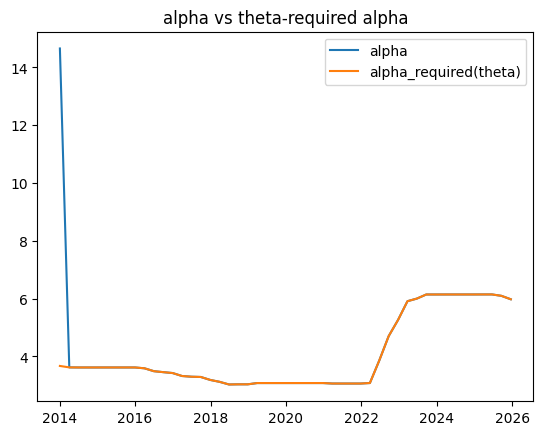

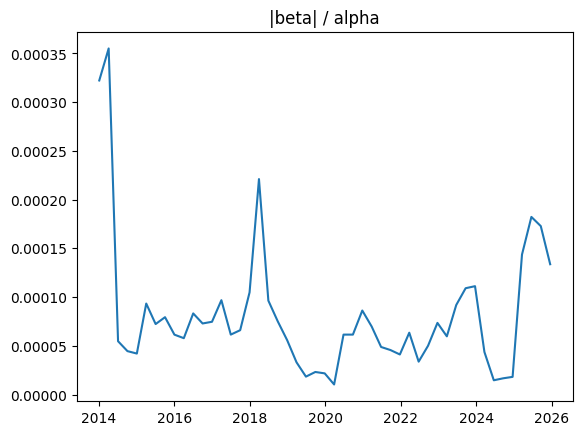

In [ ]:
upd = updates.copy()

# 1) Basic parameter stability
upd["gamma"] = np.sqrt(np.maximum(upd["alpha"]**2 - upd["beta"]**2, 0.0))
upd[["alpha","beta","gamma","delta","mu","alpha_required_from_theta"]].describe()

# 2) How binding is theta constraint?
upd["theta_binding_gap"] = upd["alpha"] - upd["alpha_required_from_theta"]
print(upd["theta_binding_gap"].describe())

plt.figure()
plt.plot(upd["date"], upd["alpha"], label="alpha")
plt.plot(upd["date"], upd["alpha_required_from_theta"], label="alpha_required(theta)")
plt.legend()
plt.title("alpha vs theta-required alpha")
plt.show()

# 4) Beta relative to alpha (should be safely inside)
plt.figure()
plt.plot(upd["date"], np.abs(upd["beta"]) / upd["alpha"])
plt.title("|beta| / alpha")
plt.show()

*Important note*:
- The period 2012–2013 is used as an initial estimation sample to (i) construct a first asset path and (ii) obtain the first NIG parameter estimates via EM.
- From 2014 onward, parameters are updated on a weekly grid using a 2-year rolling window; PDs from this period are therefore “fully model-implied” (conditioned on prior 2 years of information).

### Key Idea

If log‑asset return over horizon \( \tau \) is NIG with cumulant

$$
\kappa(u;\tau)
=
\tau\!\left(
\mu u
+
\delta\!\left(
\sqrt{\alpha^{2}-\beta^{2}}
-
\sqrt{\alpha^{2}-(\beta+u)^{2}}
\right)
\right),
$$

then

$$
\ln A_{t+\tau}
=
\ln A_t + X_\tau,
\qquad
X_\tau \sim \text{NIG}(\alpha,\beta,\delta\tau,\mu\tau),
$$

and the terminal PD at horizon \( \tau \) is

$$
\text{PD}_t(\tau)
=
\Pr(A_{t+\tau} \le L_t)
=
\Pr\!\left(
X_\tau \le \ln\!\frac{L_t}{A_t}
\right)
=
F_{\text{NIG}}\!\left(
\ln\!\frac{L_t}{A_t};
\alpha,\beta,\delta\tau,\mu\tau
\right).
$$

We will compute this using:

```
scipy.stats.norminvgauss.cdf
```

**Assumption (important):**  
SciPy’s `norminvgauss(a, b, loc, scale)` matches your  
\((\alpha,\beta,\mu,\delta)\) as:

- `a = alpha`
- `b = beta`
- `loc = mu`
- `scale = delta`

This is the standard mapping used in most implementations.

In [9]:
from nig_pd import pd_weekly_one_firm

assets_weekly = bmw_assets_w.loc[bmw_assets_w["date"] >= "2014-01-01"].copy()

weekly_pd = pd_weekly_one_firm(
    assets_weekly,
    gvkey="100022",
    param_updates=updates,
    p0=p0,
    horizon_weeks=52.0,
)

In [10]:
print(weekly_pd.head())
print(weekly_pd.shape)
print(weekly_pd.describe())

    gvkey       date         A_hat             L      alpha      beta  \
0  100022 2014-01-03  1.519031e+11  1.014480e+11  14.654713  0.004722   
1  100022 2014-01-10  1.514063e+11  1.014480e+11  14.654713  0.004722   
2  100022 2014-01-17  1.532450e+11  1.014480e+11  14.654713  0.004722   
3  100022 2014-01-24  1.507131e+11  1.014480e+11  14.654713  0.004722   
4  100022 2014-01-31  1.500636e+11  1.014480e+11  14.654713  0.004722   

      delta        mu     PD_1y  
0  0.002035  0.002343  0.000046  
1  0.002035  0.002343  0.000049  
2  0.002035  0.002343  0.000040  
3  0.002035  0.002343  0.000053  
4  0.002035  0.002343  0.000057  
(625, 9)
                      date         A_hat             L       alpha  \
count                  625  6.250000e+02  6.250000e+02  625.000000   
mean   2019-12-27 00:00:00  1.928985e+11  1.440329e+11    4.248601   
min    2014-01-03 00:00:00  1.490555e+11  1.014480e+11    3.028909   
25%    2016-12-30 00:00:00  1.825406e+11  1.294100e+11    3.078459  

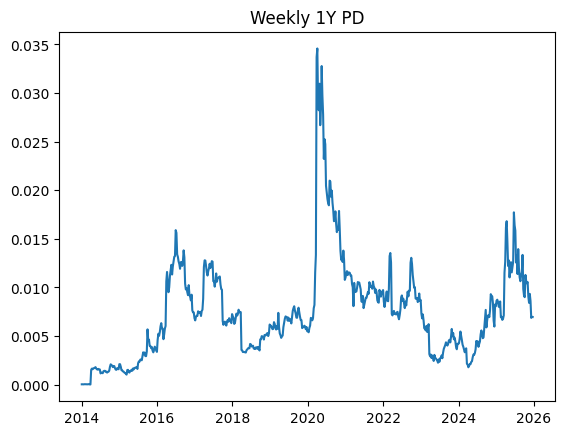

In [ ]:
plt.plot(weekly_pd["date"], weekly_pd["PD_1y"])
plt.title("Weekly 1Y PD")
plt.show()

In [14]:
print(weekly_pd["PD_1y"].between(0, 1).all(), weekly_pd["PD_1y"].isna().mean())
print(weekly_pd[["PD_1y"]].describe(percentiles=[0.5,0.9,0.95,0.99,0.995,0.999]))

weekly_pd["log_leverage"] = np.log(weekly_pd["A_hat"] / weekly_pd["L"])
print(weekly_pd[["log_leverage","PD_1y"]].corr())

True 0.0
            PD_1y
count  625.000000
mean     0.007535
std      0.005185
min      0.000029
50%      0.006875
90%      0.012709
95%      0.016361
99%      0.028502
99.5%    0.030807
99.9%    0.034023
max      0.034576
              log_leverage     PD_1y
log_leverage      1.000000 -0.687693
PD_1y            -0.687693  1.000000
